# Bangguo Wang

### Import the package

In [116]:
from __future__ import print_function
import os
import warnings
import numpy as np
import scipy.io as sio
import pandas as pd
import time
from statsmodels.tsa.stattools import acf, pacf
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import random
from statsmodels.tsa.arima_model import ARIMA
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

### Import the data

In [3]:
print('Loading data...')
datafit = sio.loadmat('datafit.mat')
X = datafit['X']
Y = np.squeeze(datafit['Y'])
print('Loaded X matrix shape:', X.shape)
print('Loaded Y vector shape:', Y.shape)

Loading data...
Loaded X matrix shape: (6600464, 8)
Loaded Y vector shape: (6600464,)


### Explore the data and clean the data

In [4]:
# fill the missing values to be zeros
X[np.isnan(X)] = 0.

In [5]:
# have a statistical summary of the data,understand what the data looks like
df_X = pd.DataFrame(X)
df_X.describe()

,0,1,2,3,4,5,6,7
count,6.600464e+06,6.600464e+06,6.600464e+06,6.600464e+06,6.600464e+06,6.600464e+06,6.600464e+06,6.600464e+06
mean,1.005634e-01,1.028804e-01,-1.654343e-03,2.993449e-02,1.645449e-01,-1.113186e-03,4.989525e-03,3.272907e-05
std,1.296341e+00,1.310005e+00,1.035418e+00,1.432779e+00,8.699561e-01,8.875600e-01,9.929882e-01,3.657981e-02
min,-4.248529e+00,-4.248529e+00,-4.248529e+00,-4.248529e+00,-4.248529e+00,-4.248529e+00,-4.248529e+00,-1.890309e+00
25%,-9.481125e-01,-9.653443e-01,-6.797848e-01,-1.067849e+00,0.000000e+00,-4.885674e-01,0.000000e+00,-9.079105e-03
50%,1.701674e-01,1.762115e-01,-2.525299e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.310618e-05
75%,1.148370e+00,1.167753e+00,4.268470e-01,1.077549e+00,0.000000e+00,4.830241e-01,0.000000e+00,8.504148e-03
max,4.248529e+00,4.248529e+00,4.248529e+00,4.248529e+00,4.248529e+00,4.248529e+00,4.248529e+00,7.251464e+01


There are 6600464 samples, 8 features. The mean of these 8 features are all very close to 0, most of the values of feature 4 and feature 6 are zeros,since their 25%,75% quantile are zero.The range of these 8 features are similar to each other, their values can be consider as in the same level, so it's not necessary to normalize the data.

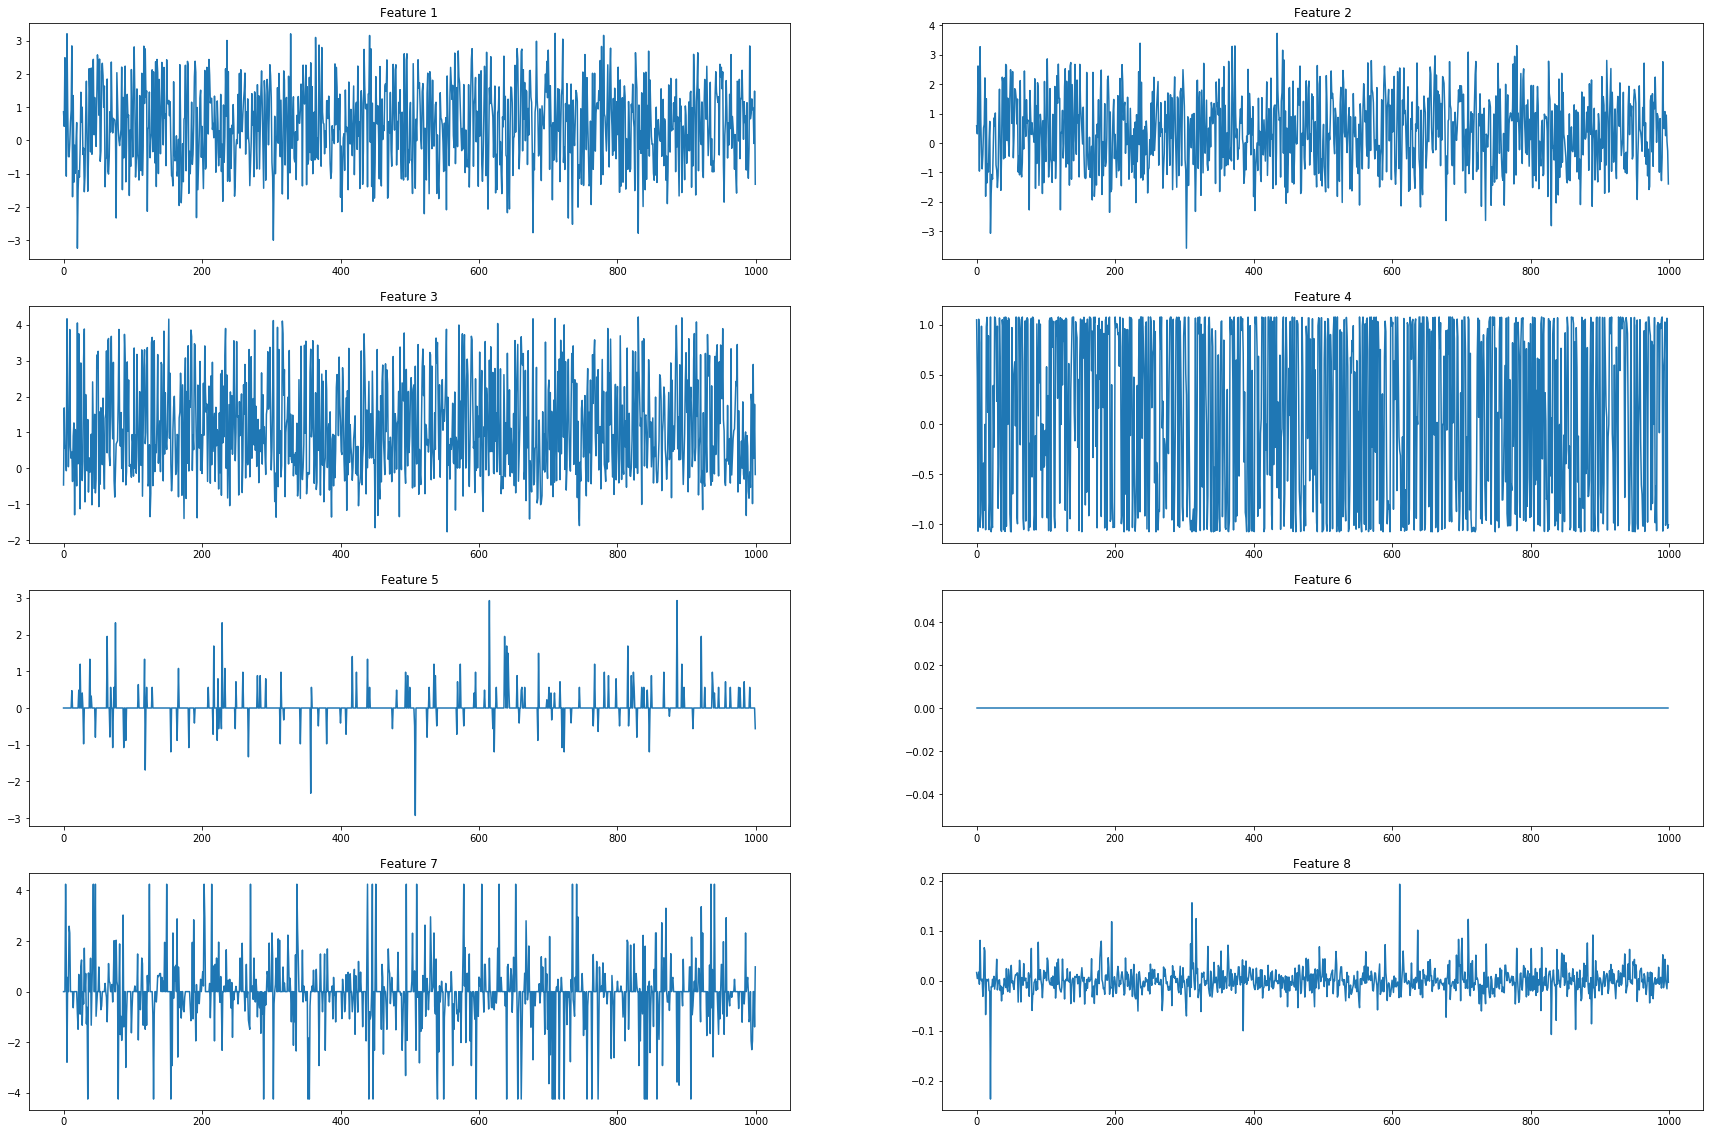

In [6]:
# see the plots of the features migth help to explore models
N = random.randint(1, int(len(X)/1000))
sample_index = np.arange(N*1000,(N+1)*1000)

plt.figure(figsize = (30,20))
plt.subplot(421) 
plt.plot(X[sample_index,0])
plt.title('Feature 1')

plt.subplot(422) 
plt.plot(X[sample_index,1])
plt.title('Feature 2')

plt.subplot(423) 
plt.plot(X[sample_index,2])
plt.title('Feature 3')

plt.subplot(424) 
plt.plot(X[sample_index,3])
plt.title('Feature 4')

plt.subplot(425) 
plt.plot(X[sample_index,4])
plt.title('Feature 5')

plt.subplot(426) 
plt.plot(X[sample_index,5])
plt.title('Feature 6')

plt.subplot(427) 
plt.plot(X[sample_index,6])
plt.title('Feature 7')

plt.subplot(428) 
plt.plot(X[sample_index,7])
plt.title('Feature 8')

plt.show()

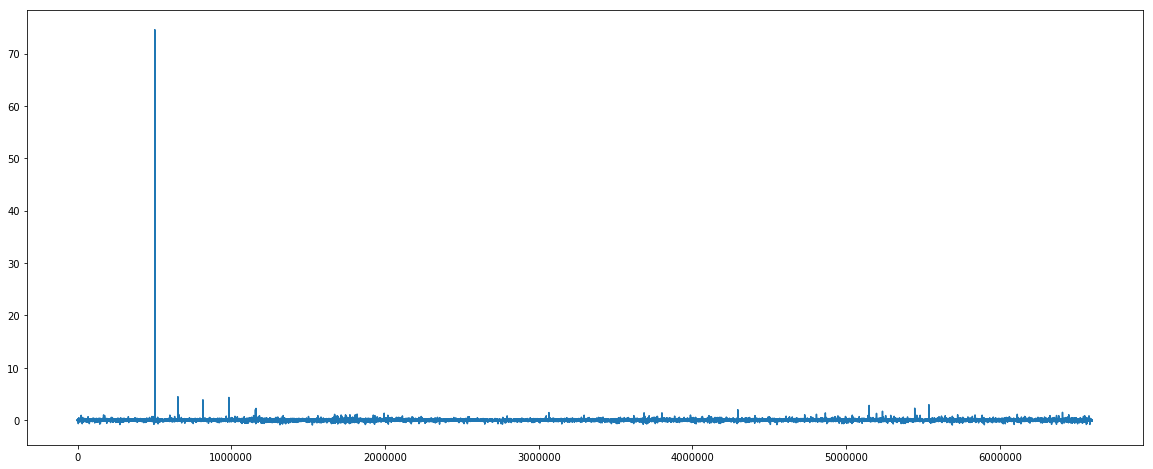

In [10]:
# see the plot of Y value
plt.figure(figsize = (20,8))
plt.plot(Y)
plt.show()

In [11]:
df_Y = pd.DataFrame(Y)
df_Y.describe()

,0
count,6.600464e+06
mean,3.499048e-04
std,4.115101e-02
min,-9.276018e-01
25%,-1.174742e-02
50%,0.000000e+00
75%,1.205087e-02
max,7.455006e+01


As we can see,most of the Y values are around zeros,while there are some outliers,like the maximum value is 7.455,while 75% quantile is just 0.012, so this must be the outlier. To avoid the model bias from the outliers,the outliers should be deleted.

In [37]:
# firstly seperate the data into train data and the test data
nrecord_train = int(Y.shape[0] * 0.8)

Original_X_train = np.copy(X[:nrecord_train, :])
Original_Y_train = np.copy(Y[:nrecord_train])

X_test = np.copy(X[nrecord_train:, :])
Y_test = np.copy(Y[nrecord_train:])

# then delete the outliers from the train data
mean_Y_train = np.mean(Original_Y_train)
sd_Y_train = np.std(Original_Y_train)
index = (Original_Y_train >= (mean_Y_train - 2 * sd_Y_train)) & (Original_Y_train <= (mean_Y_train + 2 * sd_Y_train))
print('%f%% of the train data have been deleted'%(100.0-1.0*np.sum(index)/Original_Y_train.shape[0]*100))
X_train = Original_X_train[index]
Y_train = Original_Y_train[index]

1.696926% of the train data have been deleted


Usually the value can be considered as extreme outliers when it's larger or smaller than the mean value by more than $3\sigma$. For this data set,considering there are enough data, I use $(\mu-2 \times \sigma)$ as the lower bound and $(\mu+2 \times \sigma)$ as the upper bound. And Only 1.6969% train data are deleted, so we still have lots of data to train the model. As for the test data,I'm going to keep what they are, because only the original test data can reflect the true performance of model.

## Model

In [38]:
# define the function that used to evaluate the performance of models
def evaluation_model(Y_test,Y_pred):
    #print('Evaluating model...')
    r2 = r2_score(Y_test, Y_pred)
    r_value = np.sign(r2) * np.sqrt(abs(r2))
    correlation = np.corrcoef(Y_test, Y_pred)[0, 1]
    #print('R-squared =', r2)
    #print('R value =', r_value)
    #print('Correlation =', correlation)
    return r2,r_value,correlation

# split the train data into sevaral parts,in order to evaluate the model accurately
# because this is time series data, so the cross validation method should be different from traditional one
# I use divide the train data into five parts,the first part is subset data 0:(N/5),among these subset data, 
# I'll use the first 80% data to train model and the last 20% to test model, as the metrics to pick the model
# then the second part is subset data 0:(2*N/5)... In this way,I can do the cross validation withour looking 
# the forward data
def split_train_data(x_train,y_train,folds = 5):
    N = len(x_train)
    train_dataset = {}
    for i in range(folds):
        subX = x_train[0:(i+1)*int(N/folds)]
        subY = y_train[0:(i+1)*int(N/folds)]
        n_train = int(len(subX) * 0.8)
        train_dataset[i] = {'x_train':subX[0:n_train],'x_validation':subX[n_train:],
                            'y_train':subY[0:n_train],'y_validation':subY[n_train:]}
    return train_dataset


# the function that do the cross validation
def model_crossValidation(model,train_dataset):
    all_r2 = []
    all_r_value = []
    all_correlation = []
    folds = len(train_dataset)
    for i in range(folds):
        model.fit(train_dataset[i]['x_train'],train_dataset[i]['y_train'])
        Y_pred = model.predict(train_dataset[i]['x_validation'])
        r2,r_value,correlation = evaluation_model(train_dataset[i]['y_validation'],Y_pred)
        all_r2.append(r2)
        all_r_value.append(r_value)
        all_correlation.append(correlation)
    mean_r2 = np.mean(all_r2)
    mean_r_value = np.mean(all_r_value)
    mean_correlation = np.mean(all_correlation)
    return mean_r2,mean_r_value,mean_correlation,model

### Benchmark

In [39]:
lr=LinearRegression()
lr.fit(Original_X_train,Original_Y_train)
Y_pred = lr.predict(X_test)
lr_r2,lr_r_value,lr_correlation = evaluation_model(Y_test,Y_pred)
print('R-squared = %f\nR value = %f\nCorrelation = %f'%(lr_r2,lr_r_value,lr_correlation))

R-squared = -0.000499
R value = -0.022349
Correlation = 0.007564


### Model 1: Improved Linear regression (feature selection)

In [40]:
train_dataset = split_train_data(X_train,Y_train)
lr_model = LinearRegression()
mean_r2,mean_r_value,mean_correlation,lr_model = model_crossValidation(lr,train_dataset)
print('R-squared = %f\nR value = %f\nCorrelation = %f'%(mean_r2,mean_r_value,mean_correlation))

R-squared = -0.001169
R value = -0.026316
Correlation = 0.007348


I am going to test whether the features are significant or not. If there are some insignificant features,they should be deleted.

In [41]:
est = sm.OLS(Y_train, sm.add_constant(X_train))
print(est.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     108.7
Date:                Fri, 03 Nov 2017   Prob (F-statistic):          2.42e-182
Time:                        13:03:00   Log-Likelihood:             1.2081e+07
No. Observations:             5190767   AIC:                        -2.416e+07
Df Residuals:                 5190758   BIC:                        -2.416e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   1.06e-05     29.214      0.0

For the 95% confidence level, feature $x1$ is not significant. The reason might be the multiple collinearity problem with feature $x1$ and the other 7 features. So I am going to drop out the x1 feature.

In [42]:
train_dataset = split_train_data(X_train[:,[1,2,3,4,5,6,7]],Y_train)
lr_model = LinearRegression()
mean_r2,mean_r_value,mean_correlation,lr_model = model_crossValidation(lr,train_dataset)
print('R-squared = %f\nR value = %f\nCorrelation = %f'%(mean_r2,mean_r_value,mean_correlation))

R-squared = -0.001235
R value = -0.029359
Correlation = 0.007019


As we can see, the performance of model after dropping out the feature $x_1$ is very similar to that of using the whole features,but this model potentially have better performance for the unseen data,for it avoids the multiple collinearity problem.Therefore,I finally use 7 features to construct a linear regression model.

In [43]:
# see the performance of this model on the test data
Y_pred_lr = lr_model.predict(X_test[:,[1,2,3,4,5,6,7]])
r2,r_value,correlation = evaluation_model(Y_test,Y_pred_lr)
print('R-squared = %f\nR value = %f\nCorrelation = %f'%(r2,r_value,correlation))

R-squared = -0.000151
R value = -0.012305
Correlation = 0.003528


We can see that, after the feature selection and deleting the outliers, the linear regression model improve a lot on the R-square and R value (by 0.01). Though the correlation slighly drops down (by -0.004), generally speaking, the performance is better than before.And I'll use this model as a part to construct my final ensemble model.

### Model 2: Xgboost

I'll use the xgboost to construct my second modle

In [74]:
train_dataset = split_train_data(X_train[-50000:,],Y_train[-50000:])
for max_depth in [2,4]:
    for n_estimators in [50,100,200,400]:
        model = xgb.XGBRegressor(n_estimators = n_estimators,max_depth = max_depth,learning_rate=0.05,reg_lambda=2)
        mean_r2,mean_r_value,mean_correlation,xgb_model = model_crossValidation(model,train_dataset)
        print('max_depth:%d\t n_estimators:%d'%(max_depth,n_estimators))
        print('R-squared = %f\nR value = %f\nCorrelation = %f\n'%(mean_r2,mean_r_value,mean_correlation))

max_depth:2	 n_estimators:50
R-squared = -5.528669
R value = -2.341552
Correlation = 0.025339

max_depth:2	 n_estimators:100
R-squared = -0.151697
R value = -0.320754
Correlation = 0.041145

max_depth:2	 n_estimators:200
R-squared = -0.063449
R value = -0.219501
Correlation = 0.049494

max_depth:2	 n_estimators:400
R-squared = -0.065800
R value = -0.232085
Correlation = 0.049767

max_depth:4	 n_estimators:50
R-squared = -5.531346
R value = -2.342162
Correlation = 0.018958

max_depth:4	 n_estimators:100
R-squared = -0.153714
R value = -0.348001
Correlation = 0.032850

max_depth:4	 n_estimators:200
R-squared = -0.071982
R value = -0.247477
Correlation = 0.037084

max_depth:4	 n_estimators:400
R-squared = -0.081269
R value = -0.271495
Correlation = 0.029280



From the results, I use n_estimators = 200,max_depth = 2 as the xgboost's hyperparameters

In [92]:
xgb_model = xgb.XGBRegressor(n_estimators = 200,max_depth = 2,learning_rate=0.05,reg_lambda=2)
xgb_model.fit(X_train[-200000:,],Y_train[-200000:])

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=2,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [93]:
Y_pred_xgb = xgb_model.predict(X_test)
r2,r_value,correlation = evaluation_model(Y_test,Y_pred_xgb)
print('R-squared = %f\nR value = %f\nCorrelation = %f'%(r2,r_value,correlation))

R-squared = -0.004884
R value = -0.069883
Correlation = 0.008948


Compared to the benchmark, the xgboost is better at the correlation performance,which means it's better at predict the price will up or down. So this model also can contribute to the prediction and I'll use it as a part on the ensemble model. 

### Model 3: Time series (ARMA)

In [94]:
# define the function that used to test the stationary of the time series
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize = (30,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

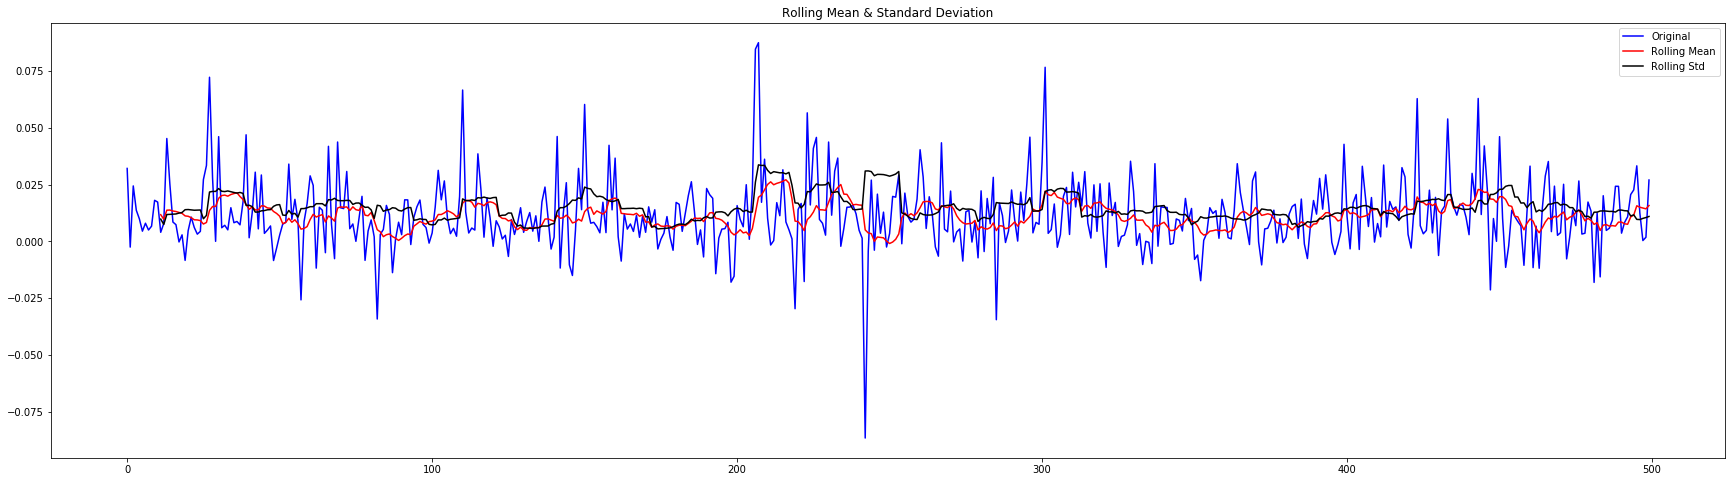

Results of Dickey-Fuller Test:
Test Statistic                 -19.835973
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    499.000000
Critical Value (5%)             -2.867350
Critical Value (1%)             -3.443523
Critical Value (10%)            -2.569864
dtype: float64


In [97]:
# to show it clear, use the latest 500 samples from the train data
Y_new_train = Y_train[-500:]
test_stationarity(Y_new_train)

The p-value is 0,which means this time series is stationary. So I'll use ARIMA model to fit the data.

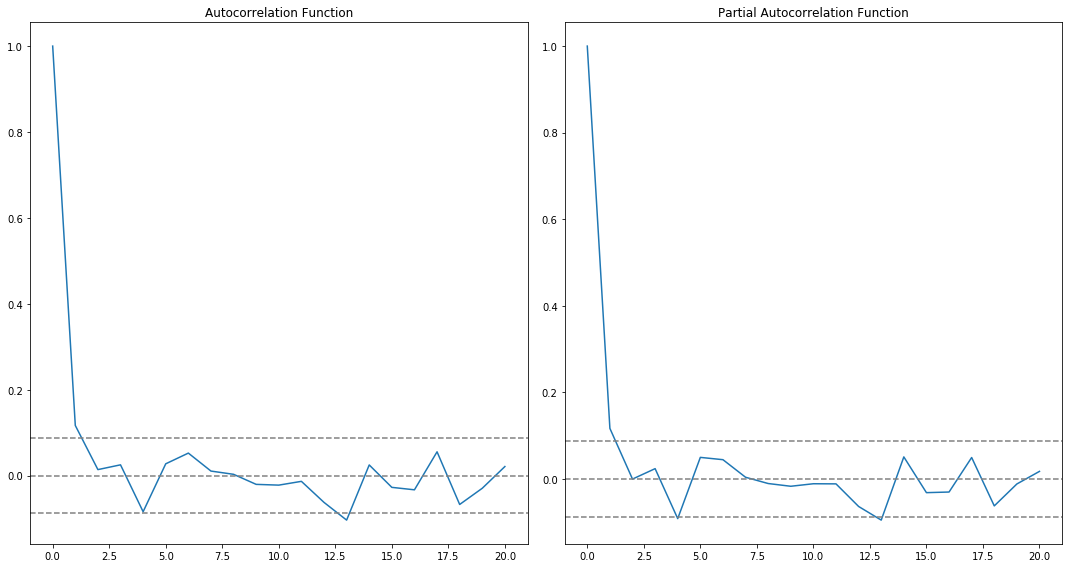

In [106]:
# judge which model can be the candidates from the acf and pacf plot
lag_acf = acf(Y_new_train, nlags=20)
lag_pacf = pacf(Y_new_train, nlags=20, method='ols')

#Plot ACF: 
plt.figure(figsize = (15,8))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Y_new_train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Y_new_train)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Y_new_train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Y_new_train)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

Both the acf and pacf are cuts off after lag 1. So I am going to test the ar(1) and ma(1) model

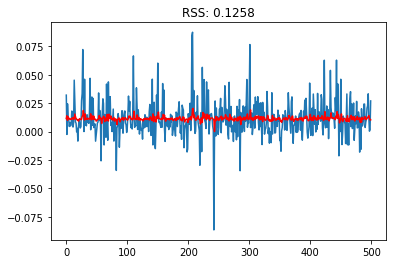

In [110]:
# AR(1)
model = ARIMA(Y_new_train, order=(1, 0, 0))  
results_AR = model.fit(disp=0)  
plt.plot(Y_new_train)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-Y_new_train)**2))
plt.show()

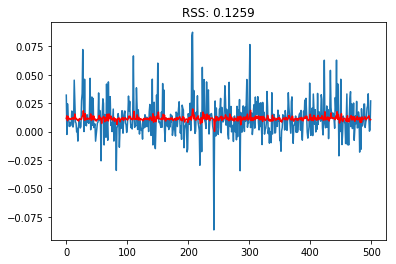

In [111]:
# MA(1)
model = ARIMA(Y_new_train, order=(0, 0, 1))  
results_MA = model.fit(disp=0)  
plt.plot(Y_new_train)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-Y_new_train)**2))
plt.show()

In [113]:
# define the function that can be used to make prediction
def arima_predict(y_train,y_test,p,q,d = 0):
    warnings.filterwarnings("ignore")
    history = [data for data in y_train]
    Y_pred = list()
    for t in range(len(y_test)):
        # for every time I make prediction,
        # I'll drop off the oldest observation and add the new observation to the train data
        # to ensure that the data are the newest 500 observations
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        Y_pred.append(yhat)
        obs = y_test[t]
        history.append(obs)
        history = history[1:]
        if t%1000 == 0:
            print('t = %d, predicted=%f, expected=%f' % (t,yhat,obs))
    Y_pred = np.ravel(Y_pred)
    return Y_pred

In [164]:
# because the computation time is pretty long,so I just use the model to predict 5000 Y_test,
# to pick the better model.And also,using the latest 500 data from the train data to estimate the parameters
Y_pred_ar1 = arima_predict(Y_train[-500:],Y_test[0:5000],p = 1,q = 0)
r2,r_value,correlation = evaluation_model(Y_test[0:5000],Y_pred_ar1)
print('R-squared = %f\nR value = %f\nCorrelation = %f'%(r2,r_value,correlation))

t = 0, predicted=0.013309, expected=0.014165
t = 1000, predicted=0.010538, expected=-0.012024
t = 2000, predicted=-0.002448, expected=-0.005430
t = 3000, predicted=-0.005618, expected=-0.022496
t = 4000, predicted=-0.006086, expected=-0.008717
R-squared = 0.154133
R value = 0.392598
Correlation = 0.395152


In [165]:
# MA(1) model prediction
Y_pred_ma1 = arima_predict(Y_train[-500:],Y_test[0:5000],p = 0,q = 1)
r2,r_value,correlation = evaluation_model(Y_test[0:5000],Y_pred_ma1)
print('R-squared = %f\nR value = %f\nCorrelation = %f'%(r2,r_value,correlation))

t = 0, predicted=0.013426, expected=0.014165
t = 1000, predicted=0.010540, expected=-0.012024
t = 2000, predicted=-0.000658, expected=-0.005430
t = 3000, predicted=-0.005629, expected=-0.022496
t = 4000, predicted=-0.006087, expected=-0.008717
R-squared = 0.151713
R value = 0.389503
Correlation = 0.392521


The result shows that AR(1) is the better one. So the following I'll use the AR(1) to predict 100000 Y_pred

In [211]:
# use the AR(1) model to predict (because it takes some time, I just use it to predict 100000 Y_pred and evaluate its performance)
Y_pred_ar1 = arima_predict(Y_train[-500:],Y_test[0:100000],p = 1,q = 0)

t = 0, predicted=0.013309, expected=0.014165
t = 1000, predicted=0.010538, expected=-0.012024
t = 2000, predicted=-0.002448, expected=-0.005430
t = 3000, predicted=-0.005618, expected=-0.022496
t = 4000, predicted=-0.006086, expected=-0.008717
t = 5000, predicted=0.004225, expected=-0.006958
t = 6000, predicted=0.001503, expected=-0.000727
t = 7000, predicted=0.000900, expected=0.009803
t = 8000, predicted=-0.002827, expected=-0.012274
t = 9000, predicted=-0.001737, expected=0.014304
t = 10000, predicted=-0.002843, expected=0.008600
t = 11000, predicted=-0.008198, expected=-0.047692
t = 12000, predicted=-0.008495, expected=-0.040685
t = 13000, predicted=-0.014757, expected=-0.027089
t = 14000, predicted=0.002122, expected=-0.002931
t = 15000, predicted=0.001276, expected=-0.000752
t = 16000, predicted=-0.000852, expected=-0.005965
t = 17000, predicted=-0.014557, expected=-0.019077
t = 18000, predicted=-0.014990, expected=-0.012950
t = 19000, predicted=-0.019246, expected=0.030856
t = 2

## Ensemble the 3 models to get the better one

In [227]:
Y_pred_ensemble = np.mean(np.array([Y_pred_lr[0:100000],Y_pred_xgb[0:100000],Y_pred_ar1[0:100000]]),axis=0)
r2,r_value,correlation = evaluation_model(Y_test[0:100000],Y_pred_ensemble)
print('R-squared = %f\nR value = %f\nCorrelation = %f'%(r2,r_value,correlation))

R-squared = 0.090289
R value = 0.300481
Correlation = 0.395810


## Conclusion

* The performance of the ensemble model on the test data is: **R-squared = 0.09,R value = 0.30,correlation = 0.40**. The benchmark is: **R-squared = -0.0005,R value = -0.022,correlation = 0.0076**. Therefore,it has beed improved greatly,compared to the benchmark. Actually, only applying the AR(1) model along is also pretty good, since the R-squred and the R value very good and if we focus more on this two metrics.But I would suggest to use the ensemble method,since it makes the prediction from different perspectives, so it can be more robust and can reduce risk to some degree. And its correlation performance is better, so if we focus more on predicting whether the price will go up or down the next day,this ensemble model is a better choice.

* Of course,there are something that should be improved. Since time is limited, I just simply use the weight average to ensemble the three models. It must be improved if use more advanced mothods like netural network (add the nonlinear transformation) to search the best way to ensemble the three models. And also, the time series model make prediction by one step, this way can be more accurate but cost some time. If it is not the high frequency trading,that's fine. If there is time requirement,we can also change it to refit the model every K steps.

* As for other models, I have tried random forest, LSTM model,etc, they cost more time but the performance does not improve much. It could be possible to have a much better performance with taking some times to tune the hyperparemeters of them or do further feature selections.